# Выбор локации для скважины

Мы работаем с добывающей компанией «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Для выполнения поставленных задач мы пройдем следующие этапы.

1. Загрузка и подготовка данных.
2. Обучение и проверка моделей для каждого региона.
3. Подготовка к расчету прибыли.
4. Расчет рисков и прибыли для каждого региона.


In [1]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-learn==1.1.3 -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import os


from pandas.plotting import scatter_matrix
from phik import phik
from scipy import stats as st
from numpy.random import RandomState

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, make_scorer)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, RobustScaler, 
                                   StandardScaler, PolynomialFeatures)
from sklearn.dummy import DummyRegressor

## Загрузка и подготовка данных

Нам известно, что каждый из трех предоставленных файлов содержит данные геологоразведки определенного региона, в них указаны уникальные номера скважин, три признака точек и данные об объеме запасов в скважине (тыс.баррелей). Для начала создадим функцию для выведения ключевой информации о данных, загрузим предоставленные файлы для работы и рассмотрим сводку о каждом датасете:

In [6]:
def analyze_geo(data):
    print(f'Первые 5 строк:\n {data.head()} \n')
    print(f'Последние 5 строк:\n {data.tail()} \n')
    print('Информация о датафрейме:')
    data.info()
    print(f'\n Количество пропущенных значений в каждом столбце:\n{data.isna().sum()} \n')
    print(f'Количество дубликатов:\n{data.duplicated().sum()} \n')
    print(f'Количество уникальных значений в каждом столбце:\n{data.nunique()}')

In [7]:
try:
    geo_df_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    geo_df_0 = pd.read_csv('C:/Users/ASUS/Desktop/PRACTICUM/Мои проекты/Объем запасов нефти/geo_data_0.csv')

In [8]:
analyze_geo(geo_df_0)

Первые 5 строк:
       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

Последние 5 строк:
           id        f0        f1        f2     product
99995  DLsed  0.971957  0.370953  6.075346  110.744026
99996  QKivN  1.392429 -0.382606  1.273912  122.346843
99997  3rnvd  1.029585  0.018787 -1.348308   64.375443
99998  7kl59  0.998163 -0.528582  1.583869   74.040764
99999  1CWhH  1.764754 -0.266417  5.722849  149.633246 

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  fl

Данные загрузились корректно, первый датасет содержит 10000 строк, сведения об id представлены в текстовом формате, основные характеристики скважины - в формате дробного числа, пропусков не обнаружено, но встречаются 10 одинаковых id с разными значениями признаков, удалим их, ведь нам необходимо предсказать объем запасов по скважинам, что подразумевает их уникальность в датасете. 

In [9]:
def drop_extra_id(data):
    data = data.drop_duplicates(subset='id')
    print(f'Количество уникальных значений в каждом столбце:\n{data.nunique()} \n')
    print(f'Размер датасета после удаления дублирующихся id: {data.shape}')
    return data

In [10]:
geo_df_0 = drop_extra_id(geo_df_0)

Количество уникальных значений в каждом столбце:
id         99990
f0         99990
f1         99990
f2         99990
product    99990
dtype: int64 

Размер датасета после удаления дублирующихся id: (99990, 5)


Удаление 10 строк датасета, в которых содержались повторяющиеся id скважин удалены.

Теперь загрузим второй файл и изучим сводную информацию о данных.

In [11]:
try:
    geo_df_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    geo_df_1 = pd.read_csv('C:/Users/ASUS/Desktop/PRACTICUM/Мои проекты/Объем запасов нефти/geo_data_1.csv')

In [12]:
analyze_geo(geo_df_1)

Первые 5 строк:
       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

Последние 5 строк:
           id         f0         f1        f2     product
99995  QywKC   9.535637  -6.878139  1.998296   53.906522
99996  ptvty -10.160631 -12.558096  5.005581  137.945408
99997  09gWa  -7.378891  -3.084104  4.998651  137.945408
99998  rqwUm   0.665714  -6.152593  1.000146   30.132364
99999  relB0  -3.426139  -7.794274 -0.003299    3.179103 

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1  

Основные характеристики датасета по второму региону идентичны первому, он тоже содержит дублирующиеся id, избавимся от них. Примечательно, что объем запасов в скважине (product) представлен только 12 значениями, что говорит о дискретности этих данных.

In [13]:
geo_df_1 = drop_extra_id(geo_df_1)

Количество уникальных значений в каждом столбце:
id         99996
f0         99996
f1         99996
f2         99996
product       12
dtype: int64 

Размер датасета после удаления дублирующихся id: (99996, 5)


Рассмотрим третий датасет.

In [14]:
try:
    geo_df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_df_2 = pd.read_csv('C:/Users/ASUS/Desktop/PRACTICUM/Мои проекты/Объем запасов нефти/geo_data_2.csv')

In [15]:
analyze_geo(geo_df_2)

Первые 5 строк:
       id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746 

Последние 5 строк:
           id        f0        f1        f2     product
99995  4GxBu -1.777037  1.125220  6.263374  172.327046
99996  YKFjq -1.261523 -0.894828  2.524545  138.748846
99997  tKPY3 -1.199934 -2.957637  5.219411  157.080080
99998  nmxp2 -2.419896  2.417221 -5.548444   51.795253
99999  V9kWn -2.551421 -2.025625  6.090891  102.775767 

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  fl

Снова избавимся от повторяющихся идентификаторов скважин. 

In [16]:
geo_df_2 = drop_extra_id(geo_df_2)

Количество уникальных значений в каждом столбце:
id         99996
f0         99996
f1         99996
f2         99996
product    99996
dtype: int64 

Размер датасета после удаления дублирующихся id: (99996, 5)


Теперь проведем исследовательский анализ данных. Создадим функцию для визуализации распределения признаков и корреляции между ними. Из-за того, что мы не располагаем данными о нормальности распределения значений, применим метод Спирмена. 

In [17]:
def dif_graphics(data, data_name):
    print(f'Статистический анализ датасета {data_name}:')
    print(f'Сводная статистика: \n{data.describe()}')
    for column in data:
        if column == 'id':
            continue
        else:
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            sns.histplot(data[column], kde=False, bins=100, ax=axes[0], color='salmon')
            axes[0].set_title(f'Гистограмма распределения {column}')
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Количество')
            
            sns.boxplot(x=data[column], ax=axes[1], color='orange')
            axes[1].set_title(f'Boxplot для столбца {column}')
            axes[1].set_xlabel(column)
            
            st.probplot(data[column], dist='norm', plot=axes[2])
            axes[2].set_title(f'Q-Q plot для столбца {column}')

            plt.show()
            
                       
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(method='spearman'), annot=True, cmap='YlOrBr', fmt=".2f")
    plt.title('Матрица корреляций признаков (метод Спирмена)')
    plt.show()
    
    sns.pairplot(data)
    plt.suptitle('Графики рассеяния признаков', y=1.02)
    plt.show()

Статистический анализ датасета geo_df_0:
Сводная статистика: 
                 f0            f1            f2       product
count  99990.000000  99990.000000  99990.000000  99990.000000
mean       0.500454      0.250141      2.502629     92.499684
std        0.871844      0.504430      3.248149     44.288304
min       -1.408605     -0.848218    -12.088328      0.000000
25%       -0.072572     -0.200877      0.287784     56.497069
50%        0.502405      0.250252      2.515969     91.847928
75%        1.073626      0.700640      4.715035    128.563699
max        2.362331      1.343769     16.003790    185.364347


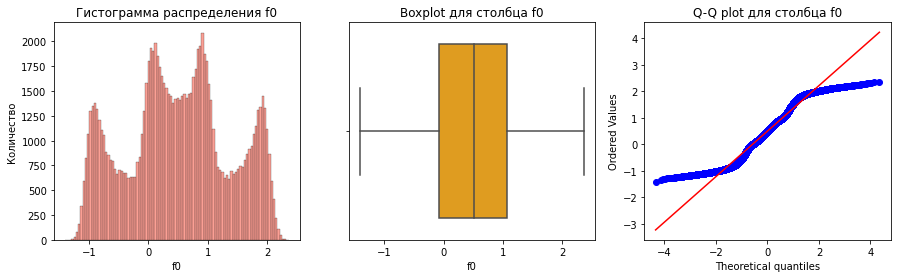

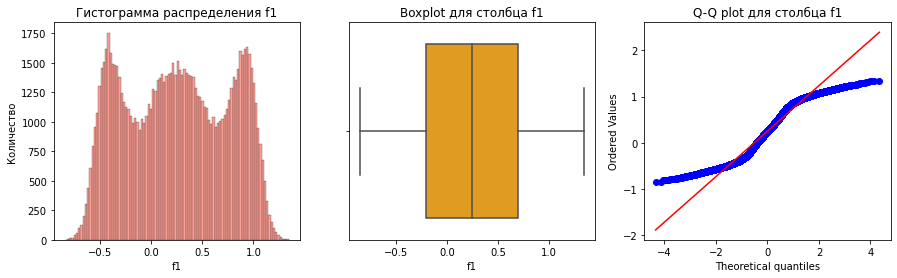

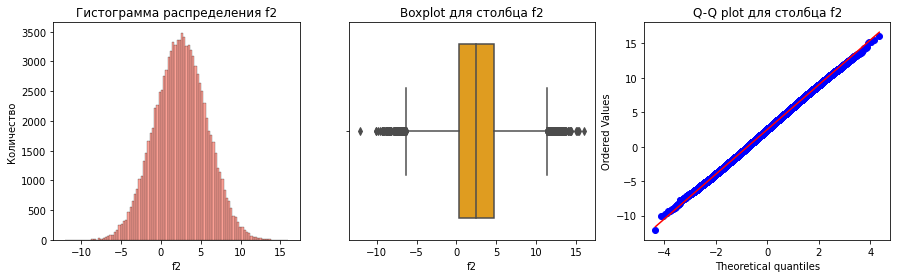

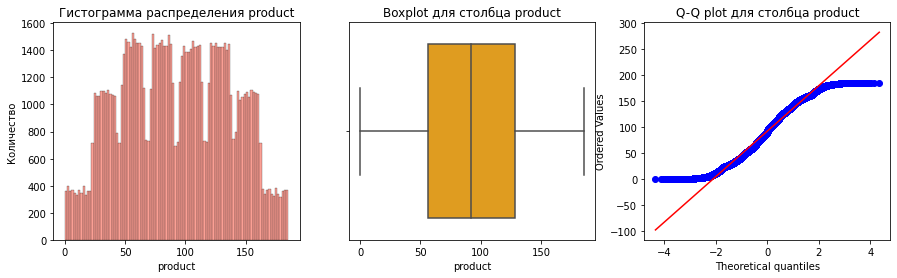

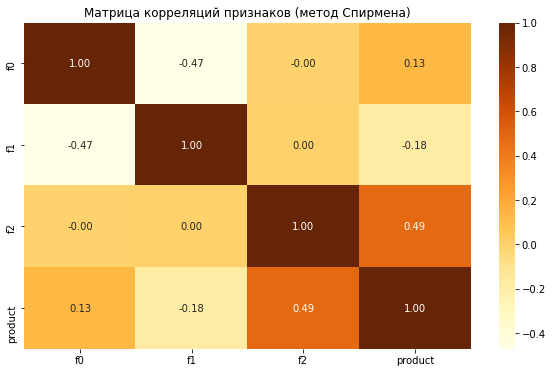

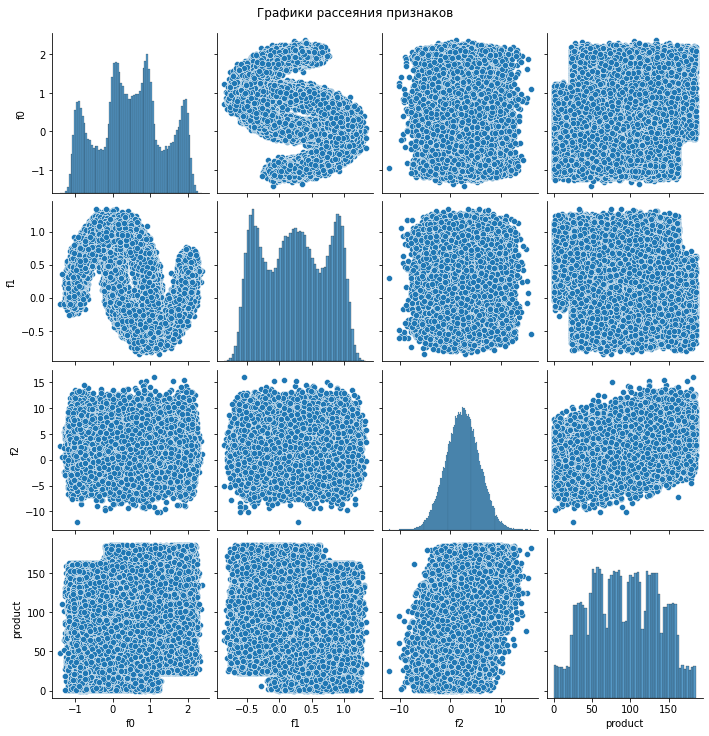

In [18]:
dif_graphics(geo_df_0, 'geo_df_0')

Судя по гистограммам распределения, только признак f2 распределен нормально, но можно предположить некоторое количество выбросов, а на графиках распределения признаков f0, f1 и product отчетливо видны пики, которые говорят о наличии группировки, например, из-за специфики сбора информации, или о мультимодальном распределении. Обращает на себя внимание нелинейная взаимосвязь признаков f0 и f1 на графиках рассеяния.

Статистический анализ датасета geo_df_1:
Сводная статистика: 
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       1.141209     -4.796608      2.494501     68.823916
std        8.965815      5.119906      1.703579     45.944663
min      -31.609576    -26.358598     -0.018144      0.000000
25%       -6.298551     -8.267985      1.000021     26.953261
50%        1.153055     -4.813172      2.011475     57.085625
75%        8.620964     -1.332816      3.999904    107.813044
max       29.421755     18.734063      5.019721    137.945408


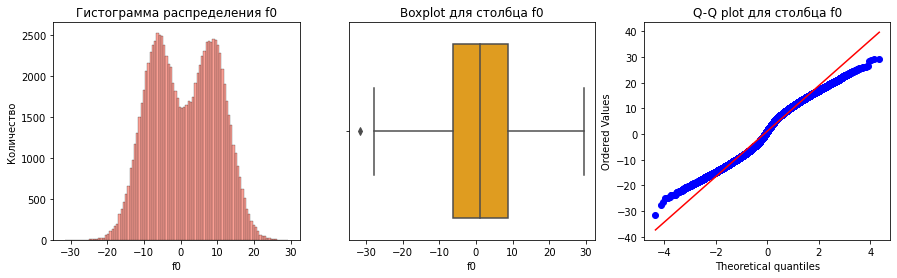

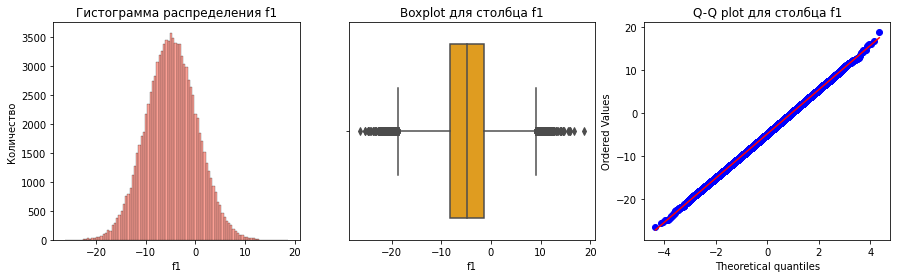

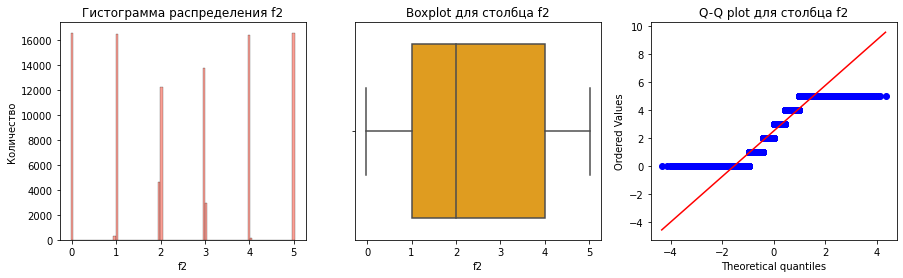

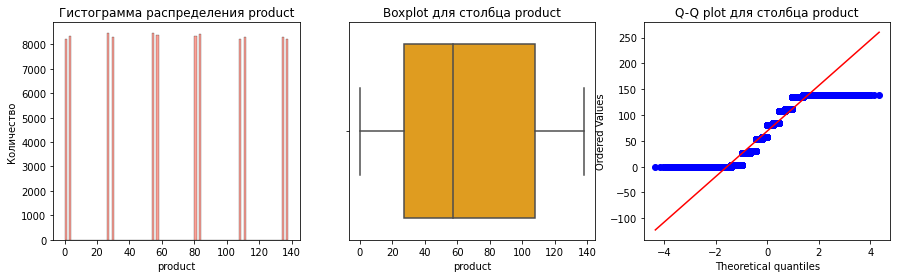

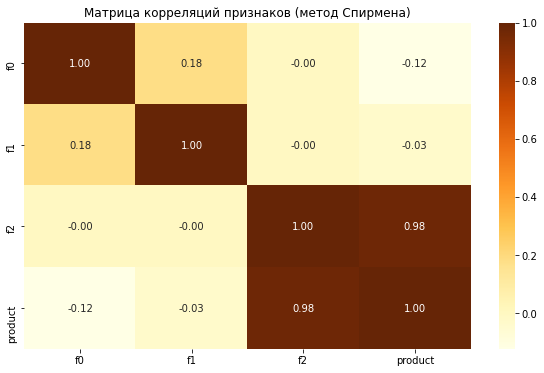

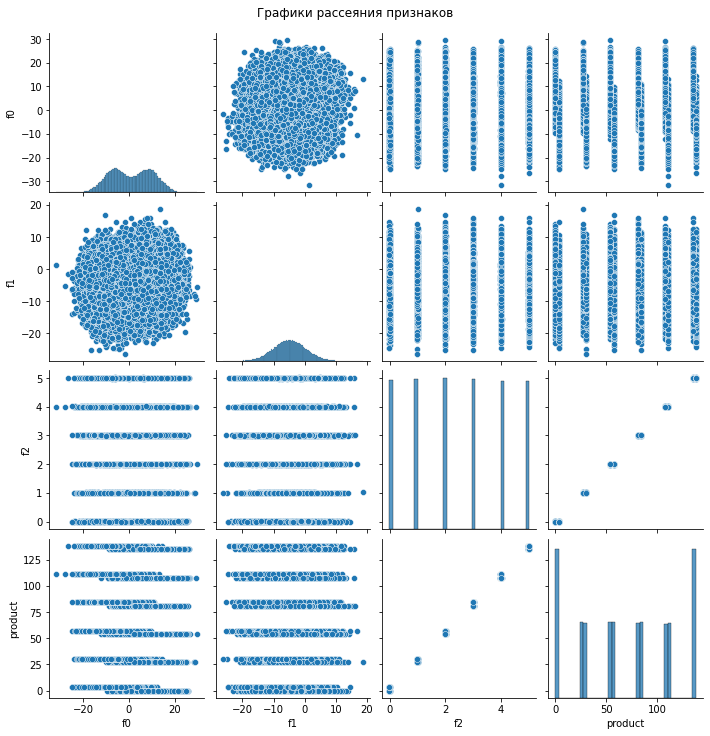

In [19]:
dif_graphics(geo_df_1, 'geo_df_1')

Распределение признака f0 говорит о его бимодальности, признак f1 распределен нормально, но графике присутствуют длинные хвосты, говорящие о выбросах, product явно имеет дискретную природу распределения, если мы округлим значения признака f2 до целых единиц, то получим тот же вывод, при этом между этими признаками наблюдается настолько тесная взаимосвязь, что можно предположить утечку целевого признака.

Статистический анализ датасета geo_df_2:
Сводная статистика: 
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       0.002002     -0.002159      2.495084     94.998342
std        1.732052      1.730397      3.473482     44.749573
min       -8.760004     -7.084020    -11.970335      0.000000
25%       -1.162328     -1.174841      0.130269     59.450028
50%        0.009424     -0.009661      2.484236     94.925026
75%        1.158477      1.163523      4.858720    130.586815
max        7.238262      7.844801     16.739402    190.029838


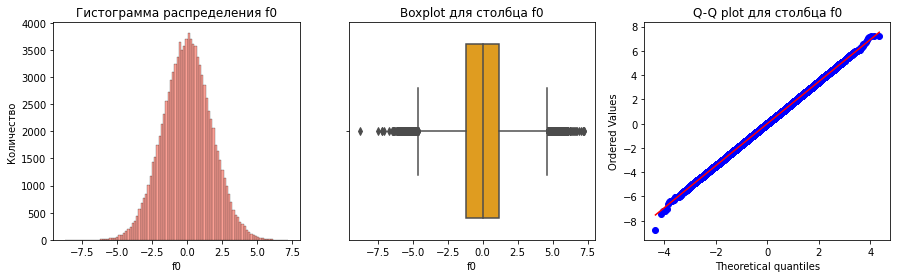

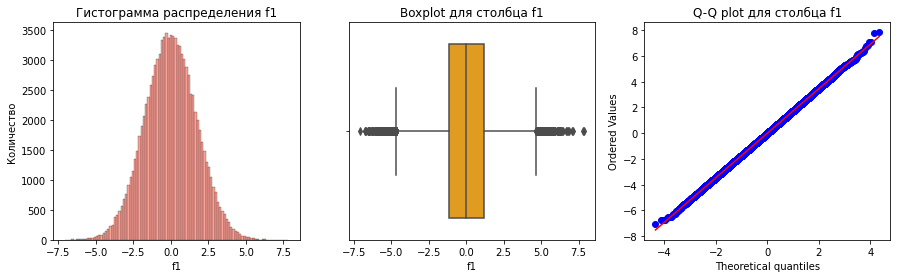

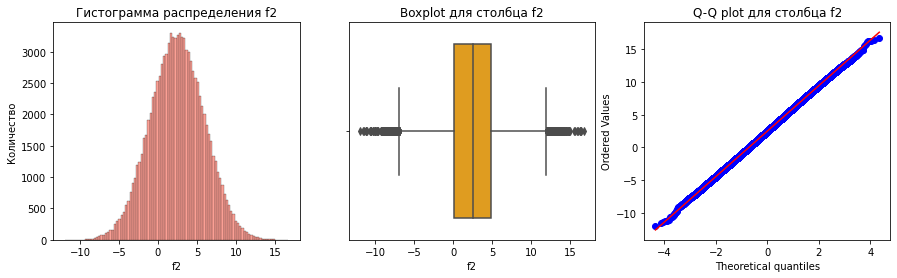

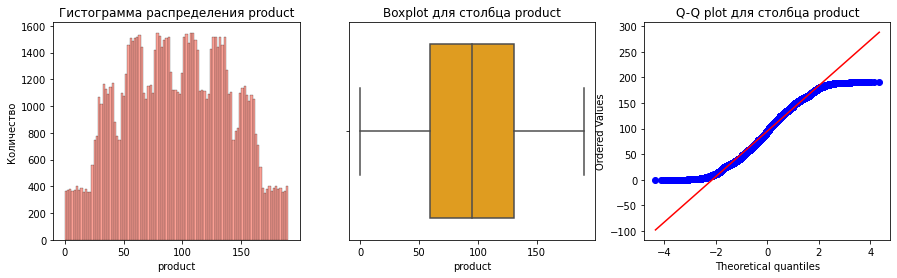

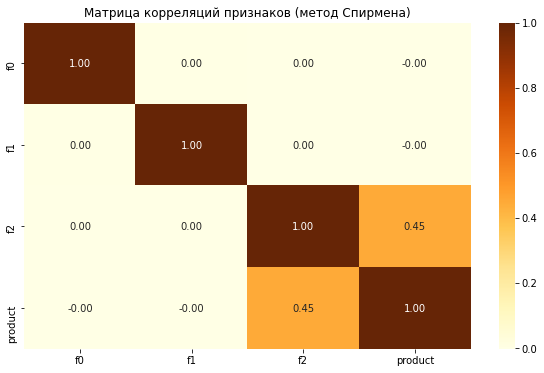

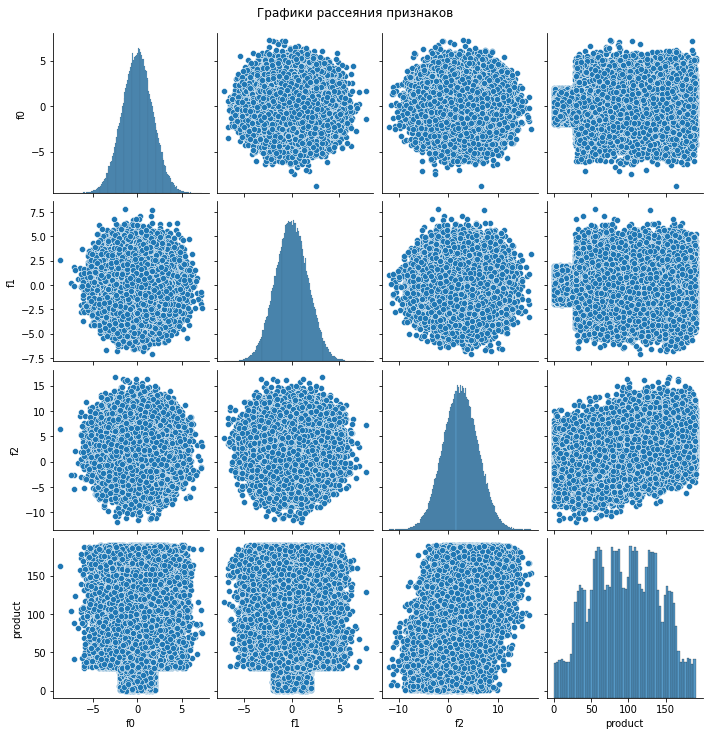

In [20]:
dif_graphics(geo_df_2, 'geo_df_2')

В третьем датасете признаки f0, f1, f2 распределены нормально, но в данных присутствуют выбросы. На графике распределения product снова наблюдаем несколько вершин, что может говорить о группах. Одинаковую форму имееют графики корреляции признаков f0 и f1 c признаком product - небольшаой группа значений целевого признака (в диапазоне от 0 до 25) свойственнен небольшой диапазон значений f0 и f1 - от -0,25 до +0,25.

**Вывод:** Из данных были удалены строки с дублирующимися номерами скважин. Средние значения целевого признака - объема запасов нефти в скважинах - отличаются по регионам: 92,5 тыс. баррелей в первом регионе, 68,8 - во втором и 95 - в третьем. Для всех регионов характерна выраженная корреляция признака f2 с объемом запасов, сильнее всего эта связь наблюдается во втором регионе, где эти значения приобретают дискретный характер. 

## Обучение и проверка модели

### Модель для первого региона

Перед нами стоит задача построения модели предсказания объема запаса нефти в новых скважинах с помощью линейной регрессии. Выделим целевой признак (product) и разделим данные первого датасета на тренировочную и валидационную выборки. Учитывая все полученные из исследовательного анализа сведения о распредлениях признаков и их взаимосвязях, создадим пайплайн для подготовки данных, чтобы применить разные способы масштабирования данных.

In [21]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(
    geo_df_0.drop(['id', 'product'], axis=1),
    geo_df_0['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

X_train_0.shape, X_test_0.shape

((74992, 3), (24998, 3))

Мы помним, что признаки f0 и f1 связаны нелинейно, поэтому попробуем сгенерировать из них полиномиальные признаки. Использование полиномиальных признаков может помочь модели уловить нелинейные зависимости между признаками и целевой переменной, что, вероятно, улучшит её качество предсказаний. Для подбора оптимальной степени возведения признаков исользуем кросс-валидацию, в гиперпараметрах пайплана переберем степени от 1 до 9.

In [22]:
preprocessing = ColumnTransformer(
    [
        ('polynomial_features', PolynomialFeatures(include_bias = False), [0, 1, 2]),
    ],
    remainder='passthrough'
)
pipe_0 = Pipeline(
    [
        ('preprocessor', preprocessing),
        ('models', LinearRegression())
    ]
)

In [23]:
param_grid_0 = {
    'preprocessor__polynomial_features__degree': list(range(1, 10)),
}

In [24]:
grid_search_0 = GridSearchCV(
    pipe_0, 
    param_grid=param_grid_0, 
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [25]:
grid_search_0.fit(X_train_0, y_train_0) 
print('Лучшая модель и её параметры:\n\n', grid_search_0.best_estimator_)
print ('Метрика r2 лучшей модели по кросс-валидации', grid_search_0.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('polynomial_features',
                                                  PolynomialFeatures(degree=7,
                                                                     include_bias=False),
                                                  [0, 1, 2])])),
                ('models', LinearRegression())])
Метрика r2 лучшей модели по кросс-валидации 0.29848709431130505


In [26]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid_search_0.cv_results_) 
result.sort_values('rank_test_score')[['rank_test_score', 'mean_test_score','params']].head(10)

,rank_test_score,mean_test_score,params
6,1,0.298487,{'preprocessor__polynomial_features__degree': 7}
4,2,0.297849,{'preprocessor__polynomial_features__degree': 5}
7,3,0.297828,{'preprocessor__polynomial_features__degree': 8}
5,4,0.297614,{'preprocessor__polynomial_features__degree': 6}
8,5,0.297326,{'preprocessor__polynomial_features__degree': 9}
2,6,0.291409,{'preprocessor__polynomial_features__degree': 3}
3,7,0.291303,{'preprocessor__polynomial_features__degree': 4}
0,8,0.275914,{'preprocessor__polynomial_features__degree': 1}
1,9,0.275895,{'preprocessor__polynomial_features__degree': 2}


Лучшие результаты показывает модель с возведением признаков в 7 степень, за счет этого мы получаем увеличение коэффициента детерминации на 0.022. Добавим в признаковое описание полиномиальные признаки с помощью полиномизации.

In [27]:
poly_0 = PolynomialFeatures(7, include_bias = False)
X_train_0_poly = poly_0.fit_transform(X_train_0)
X_test_0_poly = poly_0.transform(X_test_0)

Стандартизируем признаки с помощью скейлера RobustScaler(), потому что, как мы помним, в данных были выбросы.

In [28]:
scaler_0 = RobustScaler()
X_train_0_poly_scalled = pd.DataFrame(scaler_0.fit_transform(X_train_0_poly),columns = poly_0.get_feature_names_out())
X_test_0_poly_scalled =  pd.DataFrame(scaler_0.transform(X_test_0_poly),columns = poly_0.get_feature_names_out())

Обучим модель линейной регрессии.

In [29]:
model_0 = LinearRegression()
model_0.fit(X_train_0_poly_scalled, y_train_0)
y_pred_0 = model_0.predict(X_test_0_poly_scalled)

In [30]:
def insights(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mean_prediction = y_pred.mean()
    
    print(f'Коэффициент детерминации R^2 на тестовых данных: {r2}')
    print(f'RMSE на тестовых данных: {rmse}')
    print(f'Средний предсказанный запас сырья: {mean_prediction}')

In [31]:
insights(y_test_0, y_pred_0)

Коэффициент детерминации R^2 на тестовых данных: 0.29816831013298584
RMSE на тестовых данных: 37.06628241480705
Средний предсказанный запас сырья: 92.66877825129575


Среднее значение предсказанного запаса сырья очень близко среднему запасу в исходных данных, что говорит о том, что модель не сильно смещена и дает адекватные предсказания. RMSE намного меньше среднего значения, но относительно диапазона всех значений RMSE довольно велико.


Сравним качество предсказаний с базовой моделью DummyRegressor.

In [32]:
dummy_reg_0 = DummyRegressor(strategy='mean')
dummy_reg_0.fit(X_train_0, y_train_0)

y_pred_0_dummy = dummy_reg_0.predict(X_test_0)
print(f'Коэффициент детерминации R^2 при использовании базовых предсказаний среднего значения: {r2_score(y_test_0, y_pred_0_dummy)}')

Коэффициент детерминации R^2 при использовании базовых предсказаний среднего значения: -1.1172862252495364e-05


Коэффициент детерминации R^2 для модели линейной регрессии составляет примерно 0.298 на тестовых данных, что означает, что примерно 29.8% дисперсии целевого признака объясняется моделью. Это означает, что наша модель лучше, чем использование простого базового предсказания среднего значения, который имеет коэффициент детерминации около -1.12 x 10^(-5). Таким образом, наша модель линейной регрессии с полиномизацией признаков хотя и не идеальна, но все же предсказывает зависимую переменную лучше, чем простое среднее значение. Причина ее плохого качества может быть в недостаточности данных. Оценим общий вклад признаков в прогнозы модели с помощью SHAP-значений. 

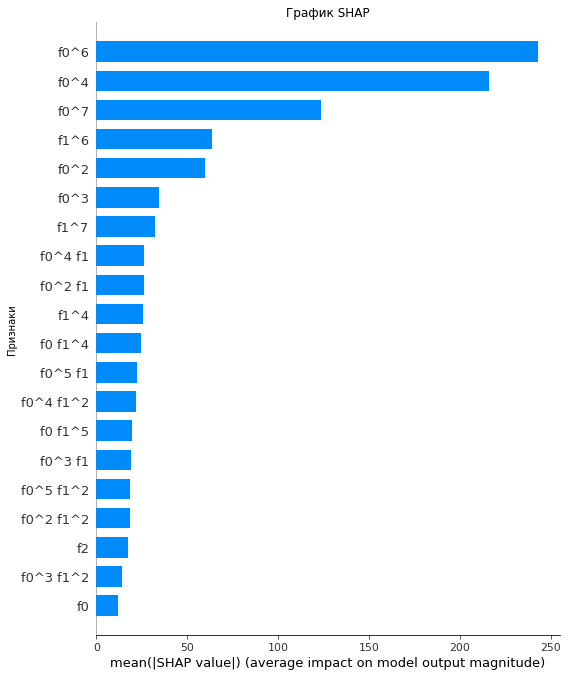

In [33]:
explainer_0 = shap.LinearExplainer(model_0, X_train_0_poly_scalled)
shap_values_0 = explainer_0(X_test_0_poly_scalled)
plt.title('График SHAP')
plt.xlabel('SHAP Value')
plt.ylabel('Признаки')
shap.summary_plot(shap_values_0, X_test_0_poly_scalled, feature_names=poly_0.get_feature_names_out(), plot_type='bar')
plt.show()

Самый большой вес у признака f0 в шестой, четвертой и седьмой степенях соответственно. В меньшей степени на прогнозы модели влияет признак f1 в шестой степени. Хуже всего объясняют целевой признаки непреобразованные f0 и f2, а также произведения возведенных в степень f0 и f1.

Теперь сохраним предсказания, сделанные на тестовой выборке, для расчета прибыли.

In [34]:
geo_val_0 = X_test_0
geo_val_0['product'] = y_test_0
geo_val_0['pred'] = y_pred_0

**Вывод:** Для прогнозирования объемов запасов в нефтяных скважинах первого региона мы использовали модель линейной регресии. В данных присутвовала сильная нелинейна связь, для этого мы применили полиномизацию. На кросс-валидации это решение подтвердилось увеличением коэффициента детерминации. На тестовых данных метрика r2 показала результат 0,298, метрика RMSE 37,06. Такой низкий результат предсказаний может быть связан с небольшим количеством признаков и недостаточностью их взаимосвязи с целевым. 

### Модель для второго региона

Выделим целевой признак из данных по второму региону и разделим данные на тренировочный и тестовый наборы.

In [35]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    geo_df_1.drop(['id', 'product'], axis=1),
    geo_df_1['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

X_train_1.shape, X_test_1.shape

((74997, 3), (24999, 3))

Во время исследовательского анализа данных мы заметили сильную корреляцию между целевым признаком и f2. Учитывая, что у нас в распоряжении только три признака на основании которых мы строим предсказания, применение решуляризации может быть излишним, и простая линейная регрессия без регуляризации может быть вполне подходящим выбором. В качестве метрики используем среднюю абсолютную ошибку, она покажет абсолютное отклонение прогнозов от фактических значений целевой переменной.

In [36]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [37]:
pipe_1 = Pipeline([
    ('preprocessor', StandardScaler()),
    ('model', LinearRegression())
])

param_grid_1 = [
    {
        'preprocessor': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    }
]

grid_search_1 = GridSearchCV(
    pipe_1, 
    param_grid=param_grid_1, 
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)

In [38]:
grid_search_1.fit(X_train_1, y_train_1)
print('Лучшие параметры модели:\n', grid_search_1.best_params_)
print('Метрика лучшей модели (RMSE) по кросс-валидации', grid_search_1.best_score_*-1)

Лучшие параметры модели:
 {'preprocessor': StandardScaler()}
Метрика лучшей модели (RMSE) по кросс-валидации 0.8896094467301927


In [39]:
result_1 = pd.DataFrame(grid_search_1.cv_results_) 
result_1['mean_test_score'] = result_1['mean_test_score']*-1
result_1.sort_values('rank_test_score')[['rank_test_score', 'mean_test_score','params']]

,rank_test_score,mean_test_score,params
0,1,0.889609,{'preprocessor': StandardScaler()}
1,2,0.889609,{'preprocessor': MinMaxScaler()}
2,2,0.889609,{'preprocessor': RobustScaler()}
3,2,0.889609,{'preprocessor': None}


In [40]:
model_1 = grid_search_1.best_estimator_
y_pred_1 = model_1.predict(X_test_1)

In [41]:
insights(y_test_1, y_pred_1)

Коэффициент детерминации R^2 на тестовых данных: 0.9996226847541325
RMSE на тестовых данных: 0.8928265978121422
Средний предсказанный запас сырья: 68.57703454115173


Высокая метрика R2 и низкая RMSE говорят о высокой точности предсказания, предсказанное среднее снова близко среднему в исходных данных.
Сравним качество предсказаний с базовой моделью DummyRegressor.

In [42]:
dummy_reg_1 = DummyRegressor(strategy='mean')
dummy_reg_1.fit(X_train_1, y_train_1)

y_pred_1_dummy = dummy_reg_1.predict(X_test_1)
print(f'Среднеквадратическая ошибка (RMSE) при использовании базовых предсказаний среднего значения: {mean_squared_error(y_test_1, y_pred_1_dummy, squared=False)}')
print(f'Коэффициент детерминации R^2 при использовании базовых предсказаний среднего значения: {r2_score(y_test_1, y_pred_1_dummy)}')

Среднеквадратическая ошибка (RMSE) при использовании базовых предсказаний среднего значения: 45.96481261084314
Коэффициент детерминации R^2 при использовании базовых предсказаний среднего значения: -4.859092382414332e-05


Обученная модель линейной регрессии показывает результаты метрик RMSE и R2 значительно лучшие, чем константная модель DummyRegressor. Визуализируем важность признаков с помощью графика shap.summary_plot().

In [43]:
X_train_1_new = pipe_1.named_steps['preprocessor'].fit_transform(X_train_1)
X_test_1_new = pipe_1.named_steps['preprocessor'].transform(X_test_1)

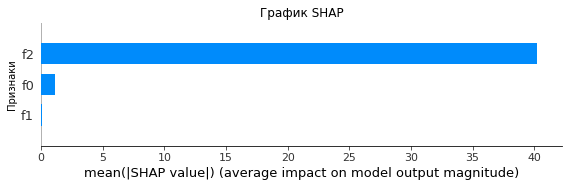

In [44]:
explainer_1 = shap.LinearExplainer(model_1.named_steps['model'], X_train_1_new)
shap_values_1 = explainer_1(X_test_1_new)
plt.title('График SHAP')
plt.xlabel('SHAP Value')
plt.ylabel('Признаки')
shap.summary_plot(shap_values_1, X_test_1_new, feature_names=pipe_1.named_steps['preprocessor'].get_feature_names_out(), plot_type='bar')
plt.show()

Признак f2 привносит наибольший вклад в предсказание модели, при этом признаки f1 и f0 имеют слабое влияние (почти не имеют).

Снова соберем предсказанные и фактические значения в один датафрейм.

In [45]:
geo_val_1 = X_test_1
geo_val_1['product'] = y_test_1
geo_val_1['pred'] = y_pred_1

**Вывод:** Среднеквадратическая ошибка (RMSE) для модели предсказаний объемов запаса нефти во втором регионе равна 0,89. Это означает, что  среднее абсолютное отклонение предсказанных значений от фактических составляет приблизительно 0.893 единицы, при текущем диапазон значений объемов запасов нефти от 0 до 137.945408 такой прогноз является достаточно точным. Около 99.96% дисперсии целевого признака объясняется моделью, таким образом, модель хорошо объясняет его вариацию. При этом SHAP анализ выявляет сильное влияние только одного признака (f2), возможно, остальные признаки в наборе данных не содержат полезной информации для прогнозирования целевой переменной.

### Модель для третьего региона

Разделим датасет с данными по третьему региону на обучающую и тестовую выборки и выделим целевой признак - product.


In [46]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    geo_df_2.drop(['id', 'product'], axis=1),
    geo_df_2['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

X_train_2.shape, X_test_2.shape

((74997, 3), (24999, 3))

Снова используем простую модель линейной регрессии и попробуем использовать разные способы масштабирования данных для определения лучшей метрики на кросс-валидации.

In [47]:
grid_search_2 = GridSearchCV(
    pipe_1, 
    param_grid=param_grid_1, 
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [48]:
grid_search_2.fit(X_train_2, y_train_2)
print('Лучшие параметры:', grid_search_2.best_params_)
print('Лучшая метрика R2 на кросс-валидации', grid_search_2.best_score_)

Лучшие параметры: {'preprocessor': StandardScaler()}
Лучшая метрика R2 на кросс-валидации 0.2000234601126693


In [49]:
result_2 = pd.DataFrame(grid_search_2.cv_results_) 
result_2.sort_values('rank_test_score')[['rank_test_score', 'mean_test_score','params']]

,rank_test_score,mean_test_score,params
0,1,0.200023,{'preprocessor': StandardScaler()}
2,1,0.200023,{'preprocessor': RobustScaler()}
3,1,0.200023,{'preprocessor': None}
1,4,0.200023,{'preprocessor': MinMaxScaler()}


Как и в предыдущих примерах, способ масштабирования данных не оказывает влияния на качество модели.

In [50]:
model_2 = grid_search_2.best_estimator_
y_pred_2 = model_2.predict(X_test_2)

In [51]:
dummy_reg_2 = DummyRegressor(strategy='mean')
dummy_reg_2.fit(X_train_2, y_train_2)

y_pred_2_dummy = dummy_reg_2.predict(X_test_2)
print(f'Коэффициент детерминации R^2 при использовании базовых предсказаний среднего значения: {r2_score(y_test_2, y_pred_2_dummy)}')

Коэффициент детерминации R^2 при использовании базовых предсказаний среднего значения: -5.8527766799709724e-05


In [52]:
insights(y_test_2, y_pred_2)

Коэффициент детерминации R^2 на тестовых данных: 0.19484623785057453
RMSE на тестовых данных: 40.080822438088305
Средний предсказанный запас сырья: 94.93478722287514


Модель объясняет около 19.48% вариации. Хотя это значение невысоко, оно гораздо лучше, чем простое предсказание среднего значения.
Посмотрим, как распределяется на графиках разница между фактическими и предсказанными значениями.

In [53]:
residuals = y_test_2 - model_2.predict(X_test_2)

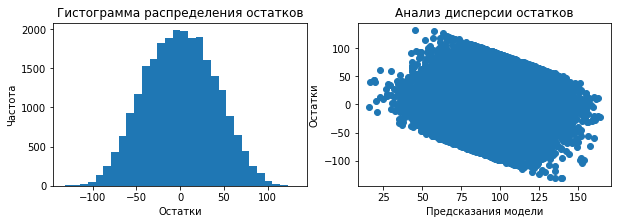

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
axes[0].hist(residuals, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')

axes[1].scatter(x=model_2.predict(X_test_2), y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии остатков')
plt.show()

Остатки расположены симметрично около нуля, но ширина гистограммы говорит о том, что модель часто допускает существенные ошибки. Судя по графику рассеяния, остатки распределены неслучайным образом - график их значений по модулю симметричен около предсказания 100.  

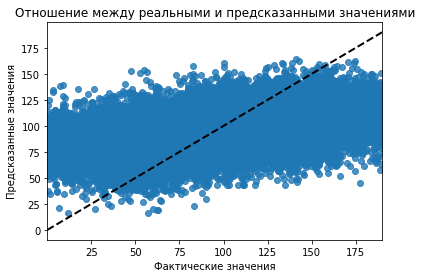

In [55]:
plt.figure(figsize=(6, 4))
sns.regplot(x=y_test_2, y=model_2.predict(X_test_2))
plt.ylabel('Предсказанные значения')
plt.xlabel('Фактические значения')
plt.title('Отношение между реальными и предсказанными значениями')
plt.plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], 'k--', lw=2)
plt.show()

Если бы модель имела хорошие предсказательные свойства, прогнозные и фактические значения находились близко к прямой, несмотря на то, что график имеет небольшой наклон, о хорошем качестве модели говорить не приходится.

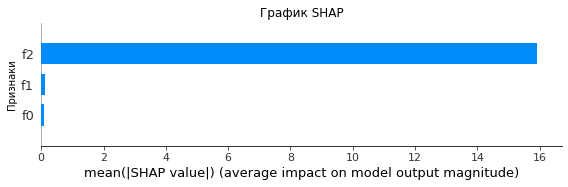

In [56]:
X_train_2_new = pipe_1.named_steps['preprocessor'].fit_transform(X_train_2)
X_test_2_new = pipe_1.named_steps['preprocessor'].transform(X_test_2)
explainer_2 = shap.LinearExplainer(model_2.named_steps['model'], X_train_2_new)
shap_values_2 = explainer_2(X_test_2_new)
plt.title('График SHAP')
plt.xlabel('SHAP Value')
plt.ylabel('Признаки')
shap.summary_plot(shap_values_2, X_test_2_new, feature_names=pipe_1.named_steps['preprocessor'].get_feature_names_out(), plot_type='bar')
plt.show()

Признаки f0 и f1 фактически не принимают участия в предсказании модели, учитываются только значения признака f2.
Подготовим данные для дальнейшего анализа.

In [57]:
geo_val_2 = X_test_2
geo_val_2['product'] = y_test_2
geo_val_2['pred'] = y_pred_2


**Вывод:** Средний предсказанный запас сырья модели линейной регрессии на тестовых данных третьего региона (94.935) достаточно близок к среднему значению в исходных данных (94.9983). Это может указывать на то, что модель не имеет заметного смещения, но может быть недостаточно точной для предсказания запасов сырья с высокой точностью. Коэффициент детерминации на тестовых данных составляет приблизительно 0.195. Это означает, что модель объясняет примерно 19.5% вариации в данных, что может быть недостаточно для точного предсказания. Среднеквадратическая ошибка (RMSE) на тестовых данных составляет около 40.081, достаточно высокое значение в контексте всего диапазона данных (0-190). Как и в предыдущем примере, признак f2 имеет значительное влияние на предсказание модели.

**ИТОГ:** 

Высокую точность демонстрирует только модель для второго региона - метрика RMSE (размер ошибки предсказания) приобретает минимальные значения, а для первого и третьего региона размер ошибки сейчас слишком большой. Точность второй модели  связана со спецификой данных - признак f2 в данных по второму региону обладает значимой информацией для обеспечения хорошей работы этой модели. При этом для всех трех регионов удалось построить модели, которые хорошо оценивают средний запас нефти. Самая точная модель сейчас относится к региону с наименьшим средним объемом запасов нефти, в этом регионе удастся использовать ресурсы бизнеса при разработке с большей эффективностью, не ошибаясь с выбором скважин, но если целью бизнеса является максимизация прибыли, то стоит рассмотреть возможности для оптимизации моделей первого и третьего регионов, например, провести дополнительное исследование, чтобы добавить новые признаки, которые имеют более сильную взаимосвязь с объемом запасов нефти. 

## Подготовка к расчёту прибыли

Итак, нам известно, что при нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей (revenue_per_unit), поскольку объём указан в тысячах баррелей. Бюджет (cost) на разработку скважин в регионе — 10 млрд рублей. Величины, выраженные в денежном эквиваленте сократим до тысяч рублей. Получается, нам необходим такой уровень запаса нефти в скважинах, чтобы после разработки, заказчик возместил свои расходы и получил прибыль. При разведке региона исследуют 500 точек (unit_amount), из которых с помощью машинного обучения выбирают 200 лучших (best_unit_amount) для разработки. Рассчитаем минимальный безубыточный объем сырья для всего региона (min_product_per_region) и средний объём сырья для безубыточной разработки новой скважины (average_product_per_unit). 

In [58]:
cost = 10_000_000 
revenue_per_unit = 450 
unit_amount = 500
best_unit_amount = 200
min_product_per_region = cost/revenue_per_unit
average_product_per_unit = min_product_per_region/best_unit_amount

In [59]:
min_product_per_region

22222.222222222223

In [60]:
average_product_per_unit

111.11111111111111

Среднее значение объема сырья для безубыточной разработки одной скважины (111,11 тыс. баррелей) значительно превышает средний запас в каждом регионе, так во втором регионе средний запас составляет 68,8 тыс. баррелей при медианном значении 57,1 тыс. баррелей. Для первого и третьего регионов разница не столь существенная, но заметна - в первом регионе в среднем запасы одной скважины составляют около 92,5 тыс. баррелей, а в третьем - 95. 

**Вывод:** Подготовка расчета прибыли позволяет оценить минимальный уровень запасов сырья, необходимый для обеспечения безубыточной разработки скважин в регионе, а также средний объем сырья для безубыточной разработки одной скважины. Минимальный безубыточный объем сырья для всего региона составляет 22 222,222 тыс. баррелей. Это означает, что в регионе должно быть добыто как минимум такое количество нефти, чтобы компенсировать все расходы на разработку скважин и начать получать прибыль.
Средний объем сырья для безубыточной разработки одной скважины составляет 111,111 тысяч баррелей. Это выше среднего запаса сырья в каждом из регионов, для успешной разработки скважины необходимо, чтобы ее запасы превышали указанное среднее значение.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Сначала отсортируем данные по региону, чтобы выделить максимальные значения предсказаний, затем просуммируем реальные значения запасов нефти, соответствующие этим предсказаниям и рассчитаем прибыль для полученного объема сырья.

In [61]:
def profit(data, count):
    product_value = data.sort_values(by='pred', ascending=False)['product'][:count].sum() * revenue_per_unit
    profit = product_value - cost
    return profit

In [62]:
print(f'Ожидаемая прибыль от разработки 200 лучших скважин, выбранных на основании предсказаний модели, составляет \n в первом регионе: {round(profit(geo_val_0, best_unit_amount), 3)} тыc. руб., \n во втором: {round(profit(geo_val_1, best_unit_amount), 3)} тыс. руб., \n в третьем: {round(profit(geo_val_2, best_unit_amount), 3)} тыс.руб.')

Ожидаемая прибыль от разработки 200 лучших скважин, выбранных на основании предсказаний модели, составляет 
 в первом регионе: 3621245.155 тыc. руб., 
 во втором: 2415086.697 тыс. руб., 
 в третьем: 2396613.001 тыс.руб.


Наибольшую прибыль способен принести первый регион, его прибыльный потенциал почти на 1,2 млрд. руб. больше чем у двух других регионов. Третий регион, с небольшим отрывом от второго, занимает последнее место по прибыльной привлекательности. 

Теперь оценим прибыль и риски для каждого региона на основе случайных подвыборок данных. Нижняя и верхняя границы 95%-го доверительного интервала укажут на диапазон, в котором может находиться ожидаемая прибыль от разработки скважин в каждом регионе. 

Согласно условиям заказчика, если вероятность убытков меньше 2,5%, это означает, что риск приемлемый. В противном случае, если вероятность убытков превышает 2,5%, это указывает на высокий риск получения убытка, связанный с разработкой скважин в регионе, в свзязи с чем решение о разработке в этом регионе не принимается.

Создадим функцию, чтобы принять решение о выборе наиболее перспективного региона для разработки скважин, учитывая ожидаемую прибыль и риски.

In [63]:
state = RandomState(12345)

In [64]:
def profit_decision(data):
    values = []
    for i in range(1000):
        product_subsample = data.sample(n=unit_amount, replace=True, random_state = state)
        values.append(profit(product_subsample, best_unit_amount))
    values=pd.Series(values)
    print(f'Нижняя граница 95% доверительного интервала: {values.quantile(0.025)}')
    print(f'Верхняя граница 95% доверительного интервала: {values.quantile(0.975)}')
    print(f'Среднее значение прибыли: {values.mean()}')
    print(f'Риск убытков: {(values < 0).mean() * 100 }%')
    if (values < 0).mean()*100 <= 2.5:
        print(f'Вероятность убытков меньше 2,5%, риск приемлемый.')
    else:
        print(f'Вероятность убытков больше 2,5%, высокий риск.')

In [69]:
profit_decision(geo_val_0)

Нижняя граница 95% доверительного интервала: -55698.26564404106
Верхняя граница 95% доверительного интервала: 967089.8748408
Среднее значение прибыли: 468137.21288431226
Риск убытков: 4.1000000000000005%
Вероятность убытков больше 2,5%, высокий риск.


In [70]:
profit_decision(geo_val_1)

Нижняя граница 95% доверительного интервала: 64278.212696567476
Верхняя граница 95% доверительного интервала: 854530.2028552539
Среднее значение прибыли: 444250.96002431284
Риск убытков: 1.5%
Вероятность убытков меньше 2,5%, риск приемлемый.


In [71]:
profit_decision(geo_val_2)

Нижняя граница 95% доверительного интервала: -151635.74920840468
Верхняя граница 95% доверительного интервала: 859023.2501624259
Среднее значение прибыли: 368634.4555386969
Риск убытков: 8.0%
Вероятность убытков больше 2,5%, высокий риск.


Наименее рисковым на данный момент является второй регион, вероятность убытков для него не превышает критического значения 2,5%, с высокой вероятностью (95%) ожидаемая прибыль от разработки скважин в регионе будет находиться в диапазоне положительных значений, средняя ожидаемая прибыль немного меньше, чем для первого региона, но эта разница покрывается минимизацией рисков. Даже при незначительном улучшении качества предсказаний модели для первого региона можно ожидать снижения вероятности убыточных разработок до приемлемого уровня, что позволит выбрать более прибыльный регион.

## Вывод:

В ходе построения моделей линейной регрессии, мы определили, что на предсказания оказывает влияние только один признак, что может указывать на то, что остальные признаки не содержат полезной информации для прогнозирования запасов нефти. Возможно, для улучшения качества модели следует провести более глубокий анализ признакового пространства и рассмотреть возможность включения дополнительных признаков или их преобразований.

Высокая точность модели для второго региона позволила обеспечить наибольшую уверенность в минимальности рисков убыточности в этом регионе.

При подготовке расчета прибыли мы оценили минимальный уровень запасов сырья, необходимый для безубыточной разработки скважин в каждом регионе, и средний объем сырья для безубыточной разработки одной скважины. Результаты бутстрэп анализа показали, что наименее рискованным вложением является второй регион, однако в случае улучшения качества предсказаний модели для первого региона с целью минимизации рисков убыточных разработок, он станет привлекательнее из-за более высокой прибыльности.
